In [26]:
%matplotlib inline

In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import sys
sys.path.insert(0,"/analysis/fabiane/phd/nitorch/")
sys.path.insert(0,"/analysis/fabiane/phd/patch_individual_filters/")

In [29]:
import os
import glob
import h5py
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.nn.modules.module import Module

# sklearn functions
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, KFold, GroupShuffleSplit

# load functions from nitorch
from nitorch.data import load_nifti
from nitorch.transforms import  ToTensor, SagittalTranslate, SagittalFlip, \
                                AxialTranslate, normalization_factors, Normalize, \
                                IntensityRescale
from nitorch.callbacks import EarlyStopping, ModelCheckpoint
from nitorch.trainer import Trainer
from nitorch.initialization import weights_init
from nitorch.metrics import balanced_accuracy, sensitivity, specificity, auc_score
from nitorch.utils import count_parameters

In [30]:
from pif import PatchIndividualFilters3D

In [31]:
torch.__version__

'1.0.0'

In [32]:
gpu = 4
multi_gpus = None #[0, 1, 2]
b = 4
zero_one_normalize = False
zoom = 0.525
dtype = np.float64

In [33]:
# load mask
mask = None

In [34]:
train_h5 = h5py.File('/ritter/share/data/MS/CIS/train_dataset.h5', 'r')
holdout_h5 = h5py.File('/ritter/share/data/MS/CIS/holdout_dataset.h5', 'r')

In [35]:
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']
X_train, y_train = train_h5['X'], train_h5['y']

In [36]:
# define dataset

In [37]:
class MSDataset(Dataset):
    def __init__(self, X, y, transform=None, target_transform=None, mask=None, z_factor=zoom, dtype=np.float32):
        self.X = np.copy(X)
        self.y = np.copy(y)
        self.transform = transform
        self.target_transform = target_transform
        self.mask = mask
        self.z_factor = zoom
        self.dtype = dtype
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx] >= 0.5
        label = torch.FloatTensor([label])
        
        # normalize by max
        image /= np.max(image)
        
        if self.transform:
            image = self.transform(image)
            
        sample = {"image" : image,
                 "label" : label}
        return sample

In [38]:
if zero_one_normalize:
    intensity = IntensityRescale()
    ms_data_train = MSDataset(X_train, y_train, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, dtype=dtype)
    ms_data_test = MSDataset(X_holdout, y_holdout, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, dtype=dtype)
else:
    ms_data_train = MSDataset(X_train, y_train, transform=transforms.Compose([ToTensor()]), mask=mask, dtype=dtype)
    ms_data_test = MSDataset(X_holdout, y_holdout, transform=transforms.Compose([ToTensor()]), mask=mask, dtype=dtype)

In [39]:
sample = ms_data_train[29]
img = sample["image"]

In [40]:
img.shape

torch.Size([1, 96, 114, 96])

Text(0.5, 1.0, '1.0')

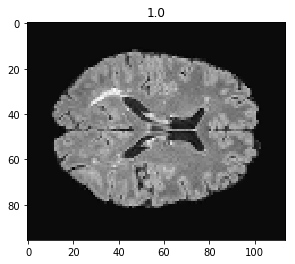

In [41]:
plt.imshow(img[0][:,:,46], cmap='gray')
plt.title(sample["label"].item())

# Define the classifier

In [42]:
class SixtyFourNet(nn.Module):
    def __init__(self, drp_rate=0.3):
        super(SixtyFourNet, self).__init__()
        self.drp_rate = drp_rate
        self.dropout = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 16, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=2, padding=0)
        self.Conv_3 = nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=0)
        self.Conv_4 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_4 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)

        self.pif = PatchIndividualFilters3D([10,13,10],
                                            filter_shape=(3,3,3),
                                            patch_shape=(5,5,5),
                                            num_local_filter_in=64,
                                            num_local_filter_out=4,
                                            overlap=1,
                                            reassemble=False,
                                            debug=False)

        self.classifier_scratch = nn.Sequential(
            nn.Linear(1512, 100),
            nn.Linear(100, 1)
        )

    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.dropout(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = self.dropout(self.pool_2(x))
        x = F.elu(self.Conv_3(h))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_4(x))
        if print_size:
            print(x.shape)
        h = F.elu(self.pif(x))
    
        return h

    def forward(self, x):
        print_size = False
        x = self.encode(x, print_size=print_size)
        x = self.flatten(x)
        x = self.classifier_scratch(x)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [43]:
if multi_gpus is None:
    net = SixtyFourNet().cuda(gpu)
else:
    net = torch.nn.DataParallel(SixtyFourNet(), device_ids=multi_gpus).cuda(gpu)

In [44]:
print("Trainable model parameters: {}".format(count_parameters(net)))

Trainable model parameters: 428545


# Training

In [20]:
def run(
    net,
    data,
    shape,
    callbacks=[],
    augmentations=[],
    masked=False,
    metrics=[],
    k_folds=None,
    b=4,
    num_epochs=35,
    retain_metric=None
):      

    all_indices = list(range(len(data)))
    train_idx, val_idx = train_test_split(all_indices, test_size=0.1, random_state=12)
    fold_metric = []
    models = []
    fold = 0
    initial_prepend = None
    
    for trial in range(10):
        print("Starting trial {}".format(trial))

        # add current fold number to model checkpoint path
        if callbacks is not None:
            for idx, callback in enumerate(callbacks):
                if isinstance(callback, ModelCheckpoint):
                    if initial_prepend is None:
                        initial_prepend = callbacks[idx].prepend
                    callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
        fold += 1

        # restart model
        del net
        net = SixtyFourNet().cuda(gpu)
        
        # reset hyperparameters
        lr = 1e-4
        wd = 1e-4
        criterion = nn.BCEWithLogitsLoss().cuda(gpu)
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)
        print("Shuffled the data..")

        # Note: is the dataset loading necessary again?
        if zero_one_normalize:
            intensity = IntensityRescale()
            ms_data_train = MSDataset(X_train, y_train, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, dtype=dtype)
        else:
            ms_data_train = MSDataset(X_train, y_train, transform=transforms.Compose([ToTensor()]), mask=mask, dtype=dtype)
        
        train_loader = DataLoader(
            ms_data_train, batch_size=b, num_workers=4, sampler=train_sampler
        )
        val_loader = DataLoader(
            ms_data_train, batch_size=1, num_workers=1, sampler=val_sampler
        )

        sample = next(iter(train_loader))
        img = sample["image"][0]
        lbl = sample["label"][0]
        print(img.shape)
        print(len(train_loader))
        plt.imshow(img.squeeze()[:,:,48], cmap='gray')
        plt.title(lbl.item())
        plt.show()
        trainer = Trainer(
            net,
            criterion,
            optimizer,
            metrics=metrics,
            callbacks=callbacks,
            device=gpu
        )
        # train model and store results
        net, report = trainer.train_model(
            train_loader,
            val_loader,
            num_epochs=num_epochs,
            show_train_steps=20,
            show_validation_epochs=1,
        )
        # append validation score of the retain metric
        if isinstance(retain_metric, str):
            fold_metric.append(report["val_metrics"][retain_metric][-1])
        else:
            fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])

        models.append(net)
        print("Finished fold.")

        # visualize result
        trainer.visualize_training(report, metrics)
        trainer.evaluate_model(val_loader, gpu)

    print("################################")
    print("################################")
    print("All accuracies: {}".format(fold_metric))
    return fold_metric, models

In [45]:
num_epochs = 200
min_iters = 3
ignore_epochs = 12
normalize = False
retain_metric = balanced_accuracy
metrics = [accuracy_score, balanced_accuracy]

In [46]:
r = 7

In [47]:
output_dir = "/ritter/share/projects/Methods/Eitel_local_filter/experiments_submission/models/MS/full_set/experiment/"
callbacks = [EarlyStopping(patience=12, ignore_before=ignore_epochs, retain_metric="loss", mode='min'),
             ModelCheckpoint(path=output_dir,
                             prepend="repeat_{}".format(r),
                             store_best=True,
                             ignore_before=ignore_epochs,
                             retain_metric=retain_metric)]

Starting trial 0
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


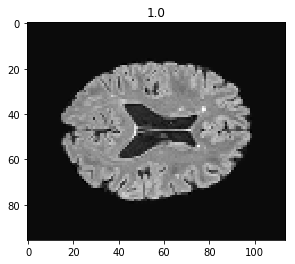

[0,    20] loss: 0.69643
Time elapsed: 0h:0m:2s
train accuracy_score: 49.55 %
train balanced_accuracy: 47.18 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.698126
[1,    20] loss: 0.69104
Time elapsed: 0h:0m:6s
train accuracy_score: 49.55 %
train balanced_accuracy: 48.66 %
val accuracy_score: 30.77 %
val balanced_accuracy: 43.06 %
Val loss: 0.703901
[2,    20] loss: 0.69530
Time elapsed: 0h:0m:9s
train accuracy_score: 54.05 %
train balanced_accuracy: 51.30 %
val accuracy_score: 38.46 %
val balanced_accuracy: 48.61 %
Val loss: 0.691152
[3,    20] loss: 0.70106
Time elapsed: 0h:0m:12s
train accuracy_score: 50.45 %
train balanced_accuracy: 50.31 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.715473
[4,    20] loss: 0.68923
Time elapsed: 0h:0m:16s
train accuracy_score: 54.05 %
train balanced_accuracy: 51.65 %
val accuracy_score: 61.54 %
val balanced_accuracy: 65.28 %
Val loss: 0.685555
[5,    20] loss: 0.69806
Time elapsed: 0h:0m:19s
trai

[43,    20] loss: 0.21758
Time elapsed: 0h:2m:27s
train accuracy_score: 91.89 %
train balanced_accuracy: 92.14 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.285490
[44,    20] loss: 0.20613
Time elapsed: 0h:2m:30s
train accuracy_score: 90.09 %
train balanced_accuracy: 90.11 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.218048
[45,    20] loss: 0.24636
Time elapsed: 0h:2m:34s
train accuracy_score: 91.89 %
train balanced_accuracy: 92.03 %
val accuracy_score: 69.23 %
val balanced_accuracy: 77.78 %
Val loss: 0.710486
[46,    20] loss: 0.13068
Time elapsed: 0h:2m:37s
train accuracy_score: 93.69 %
train balanced_accuracy: 93.84 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.273433
[47,    20] loss: 0.12555
Time elapsed: 0h:2m:40s
train accuracy_score: 94.59 %
train balanced_accuracy: 94.69 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.496470
[48,    20] loss: 0.16320
Time elapsed: 0h:2m

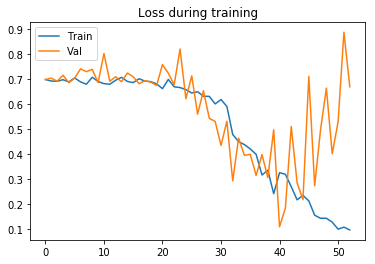

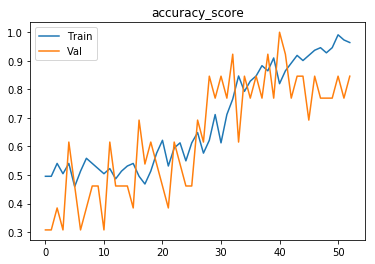

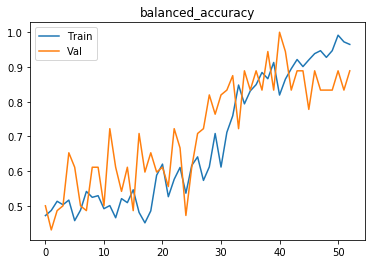

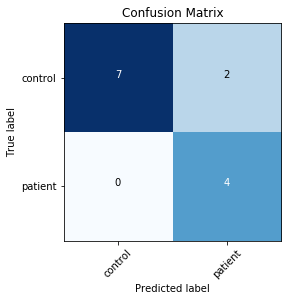

Starting trial 1
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


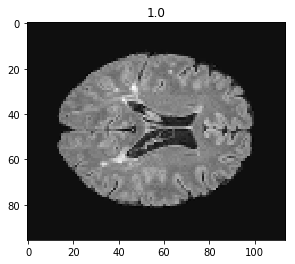

[0,    20] loss: 0.69581
Time elapsed: 0h:0m:2s
train accuracy_score: 38.74 %
train balanced_accuracy: 39.52 %
val accuracy_score: 30.77 %
val balanced_accuracy: 43.06 %
Val loss: 0.711980
[1,    20] loss: 0.70405
Time elapsed: 0h:0m:6s
train accuracy_score: 49.55 %
train balanced_accuracy: 47.98 %
val accuracy_score: 69.23 %
val balanced_accuracy: 50.00 %
Val loss: 0.672221
[2,    20] loss: 0.69896
Time elapsed: 0h:0m:9s
train accuracy_score: 49.55 %
train balanced_accuracy: 50.03 %
val accuracy_score: 76.92 %
val balanced_accuracy: 76.39 %
Val loss: 0.671598
[3,    20] loss: 0.70719
Time elapsed: 0h:0m:13s
train accuracy_score: 44.14 %
train balanced_accuracy: 44.61 %
val accuracy_score: 69.23 %
val balanced_accuracy: 56.94 %
Val loss: 0.681230
[4,    20] loss: 0.69398
Time elapsed: 0h:0m:16s
train accuracy_score: 57.66 %
train balanced_accuracy: 59.26 %
val accuracy_score: 23.08 %
val balanced_accuracy: 30.56 %
Val loss: 0.714664
[5,    20] loss: 0.69768
Time elapsed: 0h:0m:20s
trai

[43,    20] loss: 0.48805
Time elapsed: 0h:2m:29s
train accuracy_score: 76.58 %
train balanced_accuracy: 76.60 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.216274
[44,    20] loss: 0.40464
Time elapsed: 0h:2m:32s
train accuracy_score: 82.88 %
train balanced_accuracy: 82.53 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.251997
[45,    20] loss: 0.43485
Time elapsed: 0h:2m:36s
train accuracy_score: 81.08 %
train balanced_accuracy: 81.40 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.229985
[46,    20] loss: 0.38227
Time elapsed: 0h:2m:39s
train accuracy_score: 77.48 %
train balanced_accuracy: 77.44 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.187997
[47,    20] loss: 0.34940
Time elapsed: 0h:2m:43s
train accuracy_score: 84.68 %
train balanced_accuracy: 84.57 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.383067
[48,    20] loss: 0.40537
Time elapsed: 0

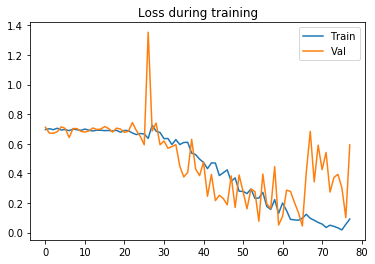

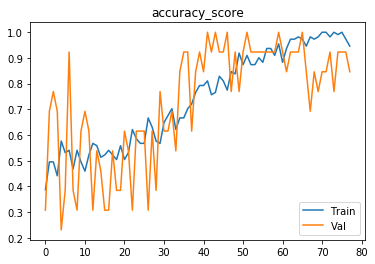

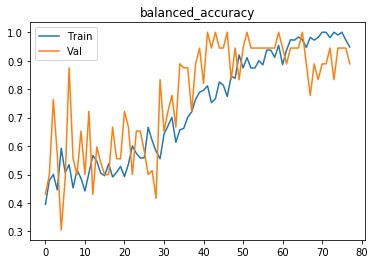

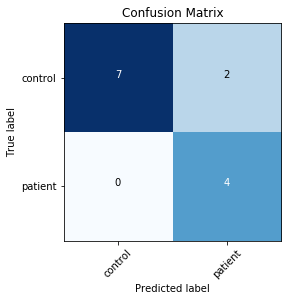

Starting trial 2
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


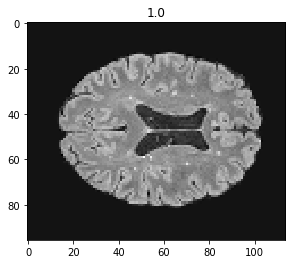

[0,    20] loss: 0.70541
Time elapsed: 0h:0m:2s
train accuracy_score: 41.44 %
train balanced_accuracy: 41.04 %
val accuracy_score: 69.23 %
val balanced_accuracy: 50.00 %
Val loss: 0.680759
[1,    20] loss: 0.69658
Time elapsed: 0h:0m:6s
train accuracy_score: 45.05 %
train balanced_accuracy: 44.20 %
val accuracy_score: 38.46 %
val balanced_accuracy: 48.61 %
Val loss: 0.696622
[2,    20] loss: 0.69253
Time elapsed: 0h:0m:9s
train accuracy_score: 53.15 %
train balanced_accuracy: 51.71 %
val accuracy_score: 46.15 %
val balanced_accuracy: 33.33 %
Val loss: 0.692662
[3,    20] loss: 0.69308
Time elapsed: 0h:0m:13s
train accuracy_score: 46.85 %
train balanced_accuracy: 44.87 %
val accuracy_score: 23.08 %
val balanced_accuracy: 37.50 %
Val loss: 0.726900
[4,    20] loss: 0.70823
Time elapsed: 0h:0m:16s
train accuracy_score: 51.35 %
train balanced_accuracy: 49.67 %
val accuracy_score: 76.92 %
val balanced_accuracy: 62.50 %
Val loss: 0.681989
[5,    20] loss: 0.69416
Time elapsed: 0h:0m:20s
trai

[43,    20] loss: 0.29580
Time elapsed: 0h:2m:30s
train accuracy_score: 87.39 %
train balanced_accuracy: 87.45 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.238331
[44,    20] loss: 0.32454
Time elapsed: 0h:2m:33s
train accuracy_score: 89.19 %
train balanced_accuracy: 89.49 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.231587
[45,    20] loss: 0.28327
Time elapsed: 0h:2m:37s
train accuracy_score: 92.79 %
train balanced_accuracy: 92.76 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.391540
[46,    20] loss: 0.18604
Time elapsed: 0h:2m:40s
train accuracy_score: 91.89 %
train balanced_accuracy: 91.92 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.352030
[47,    20] loss: 0.27422
Time elapsed: 0h:2m:44s
train accuracy_score: 87.39 %
train balanced_accuracy: 87.22 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.270877
[48,    20] loss: 0.26630
Time elapsed: 0h:2m

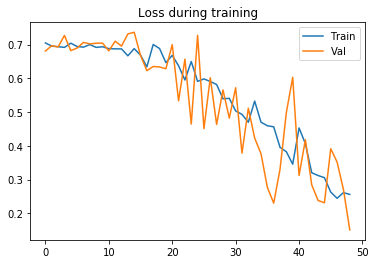

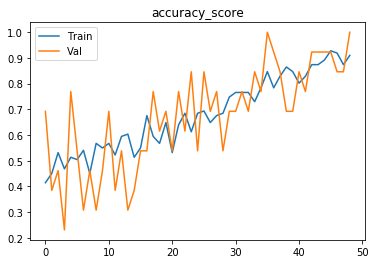

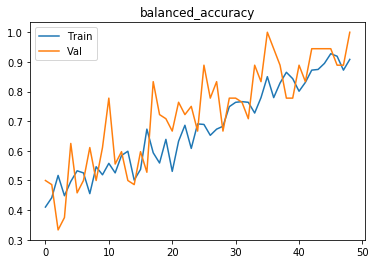

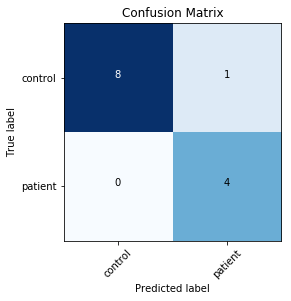

Starting trial 3
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


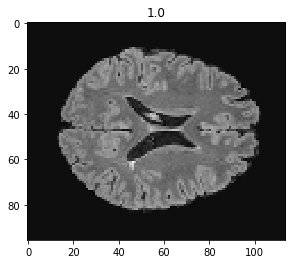

[0,    20] loss: 0.69522
Time elapsed: 0h:0m:2s
train accuracy_score: 54.05 %
train balanced_accuracy: 51.08 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.711830
[1,    20] loss: 0.69046
Time elapsed: 0h:0m:6s
train accuracy_score: 54.05 %
train balanced_accuracy: 50.96 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.704964
[2,    20] loss: 0.69258
Time elapsed: 0h:0m:9s
train accuracy_score: 53.15 %
train balanced_accuracy: 51.14 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.712505
[3,    20] loss: 0.69067
Time elapsed: 0h:0m:13s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.00 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.709849
[4,    20] loss: 0.67923
Time elapsed: 0h:0m:16s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.91 %
val accuracy_score: 61.54 %
val balanced_accuracy: 58.33 %
Val loss: 0.676854
[5,    20] loss: 0.69617
Time elapsed: 0h:0m:20s
trai

[43,    20] loss: 0.16891
Time elapsed: 0h:2m:31s
train accuracy_score: 94.59 %
train balanced_accuracy: 94.69 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.257931
[44,    20] loss: 0.16249
Time elapsed: 0h:2m:34s
train accuracy_score: 92.79 %
train balanced_accuracy: 92.88 %
val accuracy_score: 69.23 %
val balanced_accuracy: 77.78 %
Val loss: 0.961843
[45,    20] loss: 0.20030
Time elapsed: 0h:2m:38s
train accuracy_score: 93.69 %
train balanced_accuracy: 93.73 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.478054
[46,    20] loss: 0.12611
Time elapsed: 0h:2m:41s
train accuracy_score: 93.69 %
train balanced_accuracy: 93.84 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.446307
[47,    20] loss: 0.11123
Time elapsed: 0h:2m:44s
train accuracy_score: 95.50 %
train balanced_accuracy: 95.53 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.396136
[48,    20] loss: 0.18773
Time elapsed: 0h:2m

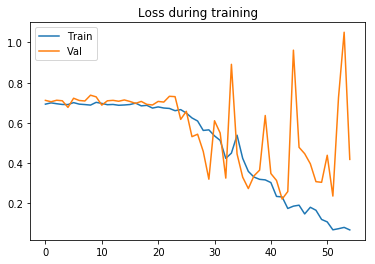

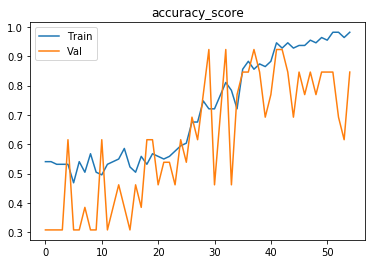

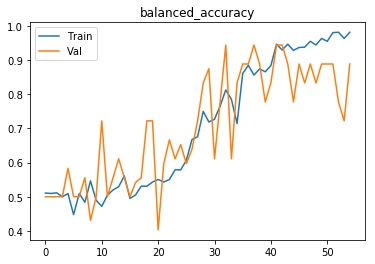

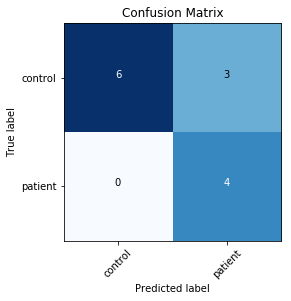

Starting trial 4
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


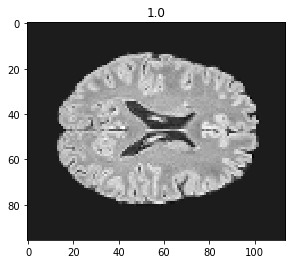

[0,    20] loss: 0.69837
Time elapsed: 0h:0m:2s
train accuracy_score: 44.14 %
train balanced_accuracy: 47.12 %
val accuracy_score: 53.85 %
val balanced_accuracy: 38.89 %
Val loss: 0.691715
[1,    20] loss: 0.70538
Time elapsed: 0h:0m:6s
train accuracy_score: 46.85 %
train balanced_accuracy: 46.12 %
val accuracy_score: 76.92 %
val balanced_accuracy: 62.50 %
Val loss: 0.684876
[2,    20] loss: 0.69550
Time elapsed: 0h:0m:9s
train accuracy_score: 50.45 %
train balanced_accuracy: 51.22 %
val accuracy_score: 46.15 %
val balanced_accuracy: 61.11 %
Val loss: 0.696733
[3,    20] loss: 0.69464
Time elapsed: 0h:0m:13s
train accuracy_score: 51.35 %
train balanced_accuracy: 49.67 %
val accuracy_score: 38.46 %
val balanced_accuracy: 55.56 %
Val loss: 0.746181
[4,    20] loss: 0.70588
Time elapsed: 0h:0m:16s
train accuracy_score: 39.64 %
train balanced_accuracy: 40.60 %
val accuracy_score: 30.77 %
val balanced_accuracy: 43.06 %
Val loss: 0.700081
[5,    20] loss: 0.69198
Time elapsed: 0h:0m:20s
trai

[43,    20] loss: 0.31348
Time elapsed: 0h:2m:30s
train accuracy_score: 89.19 %
train balanced_accuracy: 89.49 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.322333
[44,    20] loss: 0.28981
Time elapsed: 0h:2m:33s
train accuracy_score: 92.79 %
train balanced_accuracy: 92.99 %
val accuracy_score: 69.23 %
val balanced_accuracy: 77.78 %
Val loss: 0.414729
[45,    20] loss: 0.26395
Time elapsed: 0h:2m:37s
train accuracy_score: 88.29 %
train balanced_accuracy: 88.53 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.489384
[46,    20] loss: 0.18131
Time elapsed: 0h:2m:40s
train accuracy_score: 91.89 %
train balanced_accuracy: 91.92 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.221329
[47,    20] loss: 0.20575
Time elapsed: 0h:2m:44s
train accuracy_score: 92.79 %
train balanced_accuracy: 92.88 %
val accuracy_score: 61.54 %
val balanced_accuracy: 72.22 %
Val loss: 0.767483
[48,    20] loss: 0.19695
Time elapsed: 0h:2m

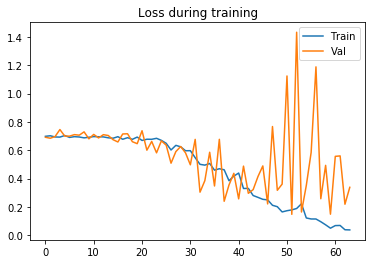

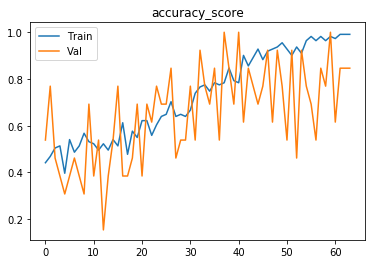

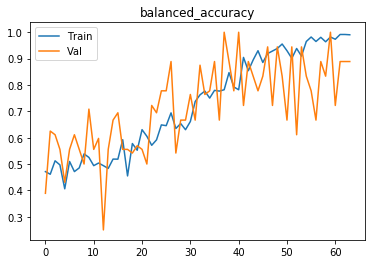

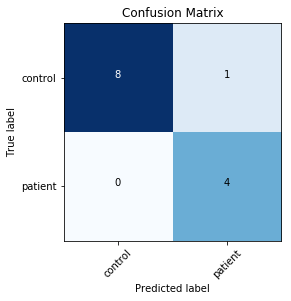

Starting trial 5
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


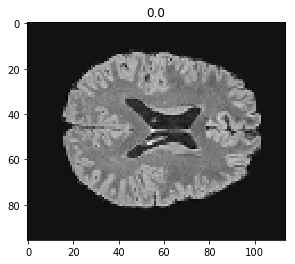

[0,    20] loss: 0.69703
Time elapsed: 0h:0m:2s
train accuracy_score: 54.05 %
train balanced_accuracy: 52.56 %
val accuracy_score: 30.77 %
val balanced_accuracy: 36.11 %
Val loss: 0.706054
[1,    20] loss: 0.70121
Time elapsed: 0h:0m:6s
train accuracy_score: 49.55 %
train balanced_accuracy: 47.52 %
val accuracy_score: 69.23 %
val balanced_accuracy: 50.00 %
Val loss: 0.687882
[2,    20] loss: 0.69705
Time elapsed: 0h:0m:9s
train accuracy_score: 45.05 %
train balanced_accuracy: 44.65 %
val accuracy_score: 23.08 %
val balanced_accuracy: 30.56 %
Val loss: 0.713427
[3,    20] loss: 0.69247
Time elapsed: 0h:0m:13s
train accuracy_score: 53.15 %
train balanced_accuracy: 51.48 %
val accuracy_score: 23.08 %
val balanced_accuracy: 30.56 %
Val loss: 0.714161
[4,    20] loss: 0.69601
Time elapsed: 0h:0m:16s
train accuracy_score: 42.34 %
train balanced_accuracy: 42.80 %
val accuracy_score: 30.77 %
val balanced_accuracy: 29.17 %
Val loss: 0.693909
[5,    20] loss: 0.69667
Time elapsed: 0h:0m:19s
trai

[43,    20] loss: 0.32906
Time elapsed: 0h:2m:31s
train accuracy_score: 85.59 %
train balanced_accuracy: 85.64 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.428143
[44,    20] loss: 0.28677
Time elapsed: 0h:2m:34s
train accuracy_score: 87.39 %
train balanced_accuracy: 87.11 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.229230
[45,    20] loss: 0.30008
Time elapsed: 0h:2m:38s
train accuracy_score: 88.29 %
train balanced_accuracy: 88.18 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.108503
[46,    20] loss: 0.25464
Time elapsed: 0h:2m:41s
train accuracy_score: 93.69 %
train balanced_accuracy: 93.84 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.079587
[47,    20] loss: 0.18181
Time elapsed: 0h:2m:44s
train accuracy_score: 94.59 %
train balanced_accuracy: 94.80 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.095680
[48,    20] loss: 0.30135
Time elapsed:

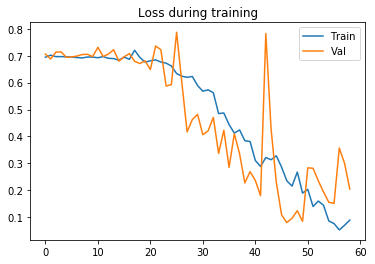

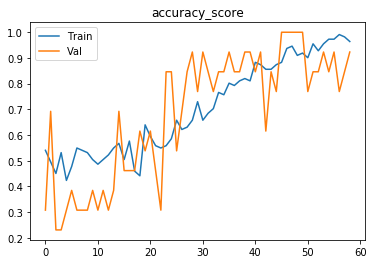

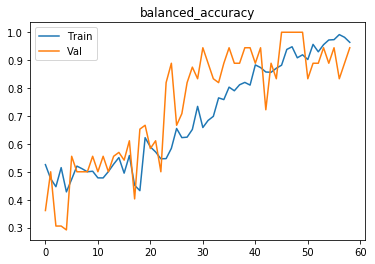

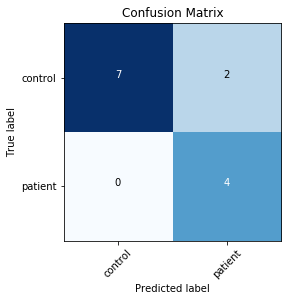

Starting trial 6
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


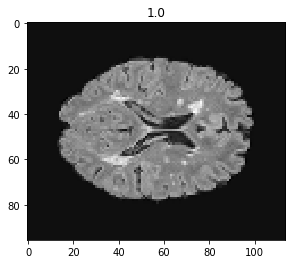

[0,    20] loss: 0.69442
Time elapsed: 0h:0m:2s
train accuracy_score: 51.35 %
train balanced_accuracy: 48.31 %
val accuracy_score: 38.46 %
val balanced_accuracy: 55.56 %
Val loss: 0.701588
[1,    20] loss: 0.69496
Time elapsed: 0h:0m:6s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.00 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.712998
[2,    20] loss: 0.69407
Time elapsed: 0h:0m:9s
train accuracy_score: 51.35 %
train balanced_accuracy: 49.56 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.699877
[3,    20] loss: 0.69422
Time elapsed: 0h:0m:13s
train accuracy_score: 54.05 %
train balanced_accuracy: 50.96 %
val accuracy_score: 38.46 %
val balanced_accuracy: 55.56 %
Val loss: 0.703091
[4,    20] loss: 0.69543
Time elapsed: 0h:0m:16s
train accuracy_score: 50.45 %
train balanced_accuracy: 48.03 %
val accuracy_score: 38.46 %
val balanced_accuracy: 55.56 %
Val loss: 0.705913
[5,    20] loss: 0.69200
Time elapsed: 0h:0m:20s
trai

[43,    20] loss: 0.20484
Time elapsed: 0h:2m:30s
train accuracy_score: 93.69 %
train balanced_accuracy: 93.73 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.160212
[44,    20] loss: 0.19177
Time elapsed: 0h:2m:33s
train accuracy_score: 91.89 %
train balanced_accuracy: 91.92 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.271203
[45,    20] loss: 0.19001
Time elapsed: 0h:2m:37s
train accuracy_score: 90.09 %
train balanced_accuracy: 89.99 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.303250
[46,    20] loss: 0.16054
Time elapsed: 0h:2m:40s
train accuracy_score: 94.59 %
train balanced_accuracy: 94.80 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.389893
[47,    20] loss: 0.15585
Time elapsed: 0h:2m:44s
train accuracy_score: 91.89 %
train balanced_accuracy: 91.80 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.141891
[48,    20] loss: 0.24579
Time elapsed: 0h:2m

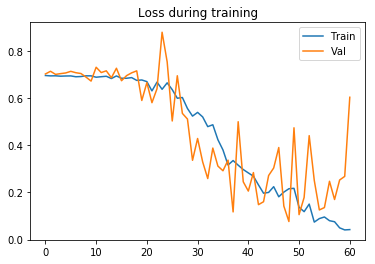

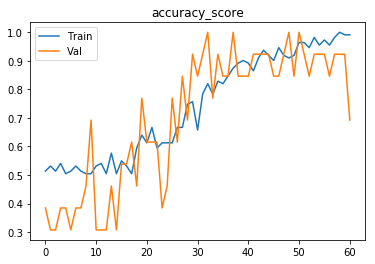

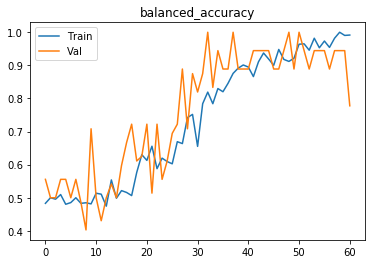

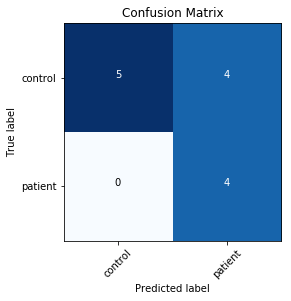

Starting trial 7
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


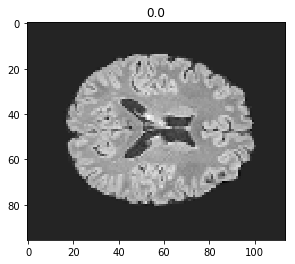

[0,    20] loss: 0.69426
Time elapsed: 0h:0m:2s
train accuracy_score: 50.45 %
train balanced_accuracy: 49.17 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.706178
[1,    20] loss: 0.69366
Time elapsed: 0h:0m:6s
train accuracy_score: 47.75 %
train balanced_accuracy: 46.17 %
val accuracy_score: 61.54 %
val balanced_accuracy: 65.28 %
Val loss: 0.692156
[2,    20] loss: 0.69783
Time elapsed: 0h:0m:9s
train accuracy_score: 41.44 %
train balanced_accuracy: 40.12 %
val accuracy_score: 38.46 %
val balanced_accuracy: 48.61 %
Val loss: 0.694904
[3,    20] loss: 0.69060
Time elapsed: 0h:0m:13s
train accuracy_score: 51.35 %
train balanced_accuracy: 48.31 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.710212
[4,    20] loss: 0.69546
Time elapsed: 0h:0m:16s
train accuracy_score: 45.95 %
train balanced_accuracy: 45.73 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.700005
[5,    20] loss: 0.69064
Time elapsed: 0h:0m:20s
trai

[43,    20] loss: 0.09880
Time elapsed: 0h:2m:31s
train accuracy_score: 96.40 %
train balanced_accuracy: 96.61 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.361942
[44,    20] loss: 0.17462
Time elapsed: 0h:2m:34s
train accuracy_score: 94.59 %
train balanced_accuracy: 94.57 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.586883
[45,    20] loss: 0.16325
Time elapsed: 0h:2m:38s
train accuracy_score: 94.59 %
train balanced_accuracy: 94.80 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.587465
[46,    20] loss: 0.11022
Time elapsed: 0h:2m:41s
train accuracy_score: 96.40 %
train balanced_accuracy: 96.50 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.253326
[47,    20] loss: 0.14231
Time elapsed: 0h:2m:45s
train accuracy_score: 95.50 %
train balanced_accuracy: 95.53 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.499882
[48,    20] loss: 0.16789
Time elapsed: 0h:2m

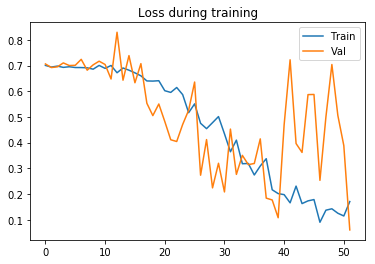

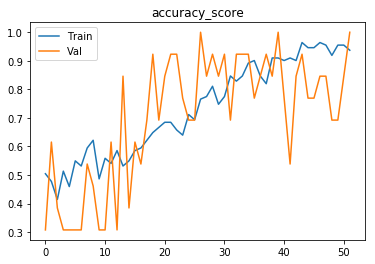

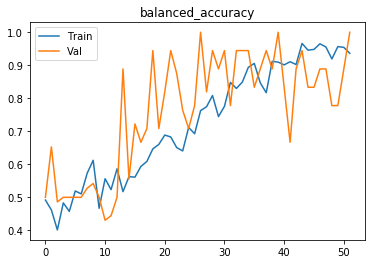

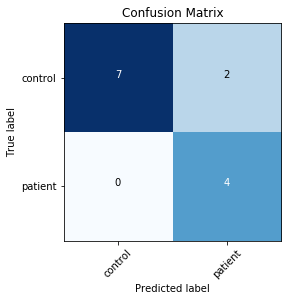

Starting trial 8
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


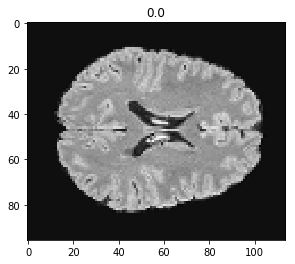

[0,    20] loss: 0.69765
Time elapsed: 0h:0m:2s
train accuracy_score: 45.05 %
train balanced_accuracy: 44.54 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.83 %
Val loss: 0.687647
[1,    20] loss: 0.69415
Time elapsed: 0h:0m:6s
train accuracy_score: 48.65 %
train balanced_accuracy: 49.41 %
val accuracy_score: 30.77 %
val balanced_accuracy: 36.11 %
Val loss: 0.712099
[2,    20] loss: 0.68507
Time elapsed: 0h:0m:9s
train accuracy_score: 55.86 %
train balanced_accuracy: 53.68 %
val accuracy_score: 30.77 %
val balanced_accuracy: 43.06 %
Val loss: 0.750204
[3,    20] loss: 0.68619
Time elapsed: 0h:0m:13s
train accuracy_score: 56.76 %
train balanced_accuracy: 55.79 %
val accuracy_score: 38.46 %
val balanced_accuracy: 34.72 %
Val loss: 0.713831
[4,    20] loss: 0.71731
Time elapsed: 0h:0m:16s
train accuracy_score: 45.05 %
train balanced_accuracy: 45.57 %
val accuracy_score: 76.92 %
val balanced_accuracy: 69.44 %
Val loss: 0.677876
[5,    20] loss: 0.69587
Time elapsed: 0h:0m:20s
trai

[43,    20] loss: 0.44117
Time elapsed: 0h:2m:31s
train accuracy_score: 77.48 %
train balanced_accuracy: 77.22 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.291347
[44,    20] loss: 0.43689
Time elapsed: 0h:2m:34s
train accuracy_score: 78.38 %
train balanced_accuracy: 78.29 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.335063
[45,    20] loss: 0.41396
Time elapsed: 0h:2m:38s
train accuracy_score: 80.18 %
train balanced_accuracy: 80.10 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.268038
[46,    20] loss: 0.35031
Time elapsed: 0h:2m:41s
train accuracy_score: 84.68 %
train balanced_accuracy: 84.57 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.343066
[47,    20] loss: 0.35824
Time elapsed: 0h:2m:45s
train accuracy_score: 84.68 %
train balanced_accuracy: 85.14 %
val accuracy_score: 69.23 %
val balanced_accuracy: 77.78 %
Val loss: 0.718519
[48,    20] loss: 0.39316
Time elapsed: 0h:

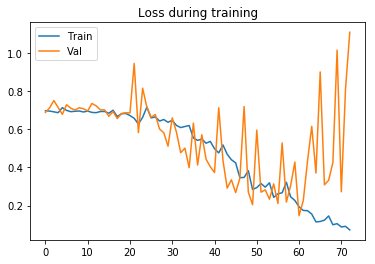

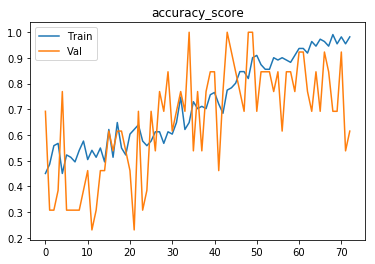

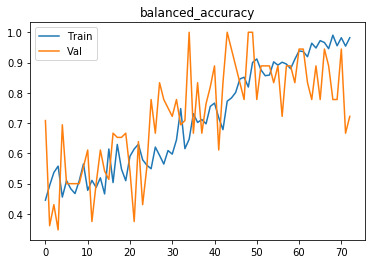

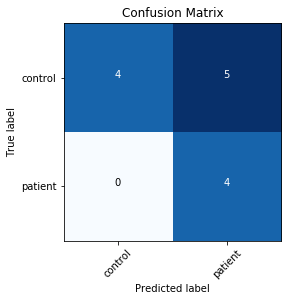

Starting trial 9
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


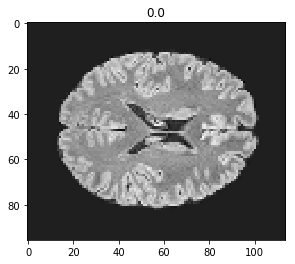

[0,    20] loss: 0.69557
Time elapsed: 0h:0m:2s
train accuracy_score: 46.85 %
train balanced_accuracy: 47.83 %
val accuracy_score: 46.15 %
val balanced_accuracy: 61.11 %
Val loss: 0.696633
[1,    20] loss: 0.69305
Time elapsed: 0h:0m:6s
train accuracy_score: 50.45 %
train balanced_accuracy: 47.57 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.712409
[2,    20] loss: 0.69868
Time elapsed: 0h:0m:9s
train accuracy_score: 43.24 %
train balanced_accuracy: 43.76 %
val accuracy_score: 53.85 %
val balanced_accuracy: 59.72 %
Val loss: 0.692710
[3,    20] loss: 0.69741
Time elapsed: 0h:0m:13s
train accuracy_score: 51.35 %
train balanced_accuracy: 48.42 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.709825
[4,    20] loss: 0.69086
Time elapsed: 0h:0m:16s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.00 %
val accuracy_score: 46.15 %
val balanced_accuracy: 61.11 %
Val loss: 0.697879
[5,    20] loss: 0.69579
Time elapsed: 0h:0m:19s
trai

[43,    20] loss: 0.47899
Time elapsed: 0h:2m:30s
train accuracy_score: 75.68 %
train balanced_accuracy: 75.41 %
val accuracy_score: 92.31 %
val balanced_accuracy: 87.50 %
Val loss: 0.270881
[44,    20] loss: 0.42978
Time elapsed: 0h:2m:34s
train accuracy_score: 78.38 %
train balanced_accuracy: 78.06 %
val accuracy_score: 84.62 %
val balanced_accuracy: 81.94 %
Val loss: 0.317330
[45,    20] loss: 0.38227
Time elapsed: 0h:2m:37s
train accuracy_score: 84.68 %
train balanced_accuracy: 84.91 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.335896
[46,    20] loss: 0.37862
Time elapsed: 0h:2m:40s
train accuracy_score: 91.89 %
train balanced_accuracy: 92.03 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.413177
[47,    20] loss: 0.35484
Time elapsed: 0h:2m:44s
train accuracy_score: 82.88 %
train balanced_accuracy: 82.87 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.365301
[48,    20] loss: 0.31998
Time elapsed: 0h:2m

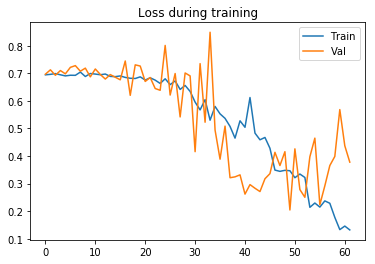

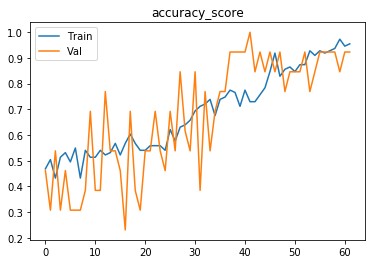

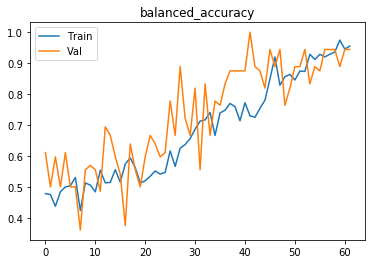

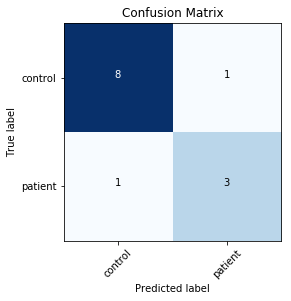

################################
################################
All accuracies: [0.8888888888888888, 0.8888888888888888, 1.0, 0.8888888888888888, 0.8888888888888888, 0.9444444444444444, 0.7777777777777778, 1.0, 0.7222222222222222, 0.9444444444444444]
0.8944444444444443
0.08407081083567532


In [24]:
fold_metric, models = run(net=net, data=ms_data_train,
                  k_folds=-1,
                  callbacks=callbacks,
                  shape=-1,
                  masked=False,
                  metrics=metrics,
                  num_epochs=num_epochs,
                  retain_metric=retain_metric,
                  b=b
                 )

print(np.mean(fold_metric))
print(np.std(fold_metric))

In [25]:
5/0

ZeroDivisionError: division by zero

# Start inference

### Using best model checkpoint for inference

In [48]:
test_loader = DataLoader(
            ms_data_test, batch_size=1, num_workers=1, shuffle=False
)

In [49]:
model_dirs = [os.path.join(output_dir,"repeat_{}_cv_fold_{}_BEST_ITERATION.h5".format(r, i)) for i in range(10)]

In [52]:
metrics = []
lr = 1e-5
wd = 1e-3
criterion = nn.BCEWithLogitsLoss().cuda(gpu)
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    
for fold, model_dir in enumerate(model_dirs):
    print("Fold {}".format(fold))

    all_scores = []
    all_preds = []
    all_labels = []
    
    net = SixtyFourNet()
    net.load_state_dict(torch.load(model_dir))
    net = net.cuda(gpu)
    net.eval()
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]
            img = img.to(torch.device("cuda:" + str(gpu)))
            
            output = net.forward(img)
            score = torch.sigmoid(output)
            pred = score >= 0.5
            
            all_scores.append(score.cpu().numpy().item())
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
    
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    roc_score = roc_auc_score(all_labels, all_scores)
    sens = sensitivity(all_labels, all_preds)
    spec = specificity(all_labels, all_preds)
    print("Bal. accuracy {:.3f} %".format(balanced_acc*100))
    print("ROC AUC Score {:.3f} %".format(roc_score*100))
    print("Sensitivity {:.3f} %".format(sens*100))
    print("Specificity {:.3f} %".format(spec*100))
    metrics.append([balanced_acc, roc_score, sens, spec])
# reset network to training mode6
net.train()
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics, columns=["Bal Acc", "ROC AUC", "Sensitivity", "Specificity"])
print(metrics_df)
print("Balanced accuracy mean {:.3f} %".format(np.mean(metrics_df["Bal Acc"])*100))
print("ROC AUC mean {:.3f} %".format(np.mean(metrics_df["ROC AUC"])*100))
print("Sensitivity mean {:.3f} %".format(np.mean(metrics_df["Sensitivity"])*100))
print("Specificity mean {:.3f} %".format(np.mean(metrics_df["Specificity"])*100))

Fold 0
Bal. accuracy 83.462 %
ROC AUC Score 91.538 %
Sensitivity 76.923 %
Specificity 90.000 %
Fold 1
Bal. accuracy 83.462 %
ROC AUC Score 96.923 %
Sensitivity 76.923 %
Specificity 90.000 %
Fold 2
Bal. accuracy 76.154 %
ROC AUC Score 84.615 %
Sensitivity 92.308 %
Specificity 60.000 %
Fold 3
Bal. accuracy 91.154 %
ROC AUC Score 94.615 %
Sensitivity 92.308 %
Specificity 90.000 %
Fold 4
Bal. accuracy 81.154 %
ROC AUC Score 91.538 %
Sensitivity 92.308 %
Specificity 70.000 %
Fold 5
Bal. accuracy 85.000 %
ROC AUC Score 93.846 %
Sensitivity 100.000 %
Specificity 70.000 %
Fold 6
Bal. accuracy 90.000 %
ROC AUC Score 95.385 %
Sensitivity 100.000 %
Specificity 80.000 %
Fold 7
Bal. accuracy 83.462 %
ROC AUC Score 90.000 %
Sensitivity 76.923 %
Specificity 90.000 %
Fold 8
Bal. accuracy 68.462 %
ROC AUC Score 83.846 %
Sensitivity 76.923 %
Specificity 60.000 %
Fold 9
Bal. accuracy 63.462 %
ROC AUC Score 73.077 %
Sensitivity 76.923 %
Specificity 50.000 %
######## Final results ########
    Bal Acc   RO

In [29]:
metrics = []
lr = 1e-5
wd = 1e-3
criterion = nn.BCEWithLogitsLoss().cuda(gpu)
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    
for fold, model_dir in enumerate(model_dirs):
    print("Fold {}".format(fold))

    all_preds = []
    all_labels = []
    net = SixtyFourNet()
    net.load_state_dict(torch.load(model_dir))
    net = net.cuda(gpu)
    net.eval()
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]

            img = img.to(torch.device("cuda:" + str(gpu)))

            output = net.forward(img)
            pred = torch.sigmoid(output) >= 0.5
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
    
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    print(balanced_acc)
    net.train()
    metrics.append(balanced_acc)
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics)
print(metrics_df)
print("Balanced accuracy mean {:.2f} %".format(np.mean(metrics_df[0])*100))

Fold 0
0.8346153846153846
Fold 1
0.8346153846153846
Fold 2
0.7
Fold 3
0.9115384615384616
Fold 4
0.8115384615384615
Fold 5
0.8615384615384616
Fold 6
0.9
Fold 7
0.6961538461538461
Fold 8
0.773076923076923
Fold 9
0.6230769230769231
######## Final results ########
          0
0  0.834615
1  0.834615
2  0.700000
3  0.911538
4  0.811538
5  0.861538
6  0.900000
7  0.696154
8  0.773077
9  0.623077
Balanced accuracy mean 79.46 %
